In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc
import os
import re
import pickle
import sklearn
import sys
import string


from datetime import datetime
from sklearn.externals import joblib
from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.delicious_t140
%aimport src.helpers.labels
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [4]:
from src.features.delicious_t140 import clean_text_delicious
from src.data.delicious_t140 import get_sample_from_cache
from src.helpers.labels import truncate_labels
from src.utils.metrics import ranking
from src.utils.dataframes import sample_rows
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/delicious-knn-tf-idf")
DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140"
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/delicious-t140/")
OUTPUT_FILE = 'output-knn-tf-idf-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

MAX_NB_WORDS = 1000
SEED= 42
MIN_TAG_DF=10
SAMPLE_FRAC=20

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = get_sample_from_cache(INTERIM_DATA_ROOT,SAMPLE_FRAC)

In [8]:
docs_df.head(1)

,filename,filetype,hash,tags,url,num_users,num_tags,contents
0,26313806abe42032de4f612017738426.html,html,26313806abe42032de4f612017738426,"tutoriel,multimedia,english,screencasts,videos...",http://screencasts.ubuntu.com/,228,23,"Ubuntu Screencasts @import ""/misc/drupal.css""..."


In [9]:
len(docs_df)

28743

In [10]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))
labels = truncate_labels(labels,MIN_TAG_DF)

In [11]:
np.random.seed(SEED)

mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['contents'].values
indices = np.arange(len(data))
np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 3305 
total number of train documents: 24432
total number of validation documents: 4311


### these parameters were found via grid search

In [15]:
g = { 
        "vect__max_features": 1000,
        "vect__norm": 'l2',
        "nn__n_neighbors":75,
        "nn__metric":"manhattan"
    }

In [17]:
%%time

vect=TfidfVectorizer().set_params(**dict([(re.sub('^vect__','',k),v) for (k,v) in g.items() if k.startswith('vect__') ]))
vect.fit(X_train)

X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)

nbrs = NearestNeighbors().set_params(**dict([(re.sub('^nn__','',k),v) for (k,v) in g.items() if k.startswith('nn__') ]))
nbrs.fit(X_train_vect)

# just to make it easier to use it
k = nbrs.n_neighbors

# distance matrix shape: (num_validation_documents, k)
# indices matrix shape: (num_validation_documents, k)
distances_matrix_val, indices_matrix_val = nbrs.kneighbors(X_val_vect)

# shape: (num_validation_documents, k, num_tags)
neighbour_labels_tensor_val = Y_train[indices_matrix_val]

Y_pred_val = []

# for every validation document do
for i in range(distances_matrix_val.shape[0]):
    # these are the labels from the neighbours of test document i
    # shape: (k, num_tags)
    neighbor_labels = neighbour_labels_tensor_val[i,:,:]

    # these are the distances from test document i to the nearest neighbours
    # shape: (k, )
    distances_to_neighbors = distances_matrix_val[i]

    # sum the contributions from all neighbors, for all tags
    # no need to normalize because we're only interested in the order
    y_preds = neighbor_labels.sum(axis=0)

    Y_pred_val.append(y_preds)

Y_pred_val = np.array(Y_pred_val)

ks = [1,2,3,4,5,6,7,8,9,10]

# k is the number of neighbors so let's use at_k
for at_k in ks:
    print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 

print('')    

validation micro-F1 @1: 0.4542846898529939
validation micro-F1 @2: 0.4152191894127378
validation micro-F1 @3: 0.3993811881188119
validation micro-F1 @4: 0.38577112099227706
validation micro-F1 @5: 0.3732075471698113
validation micro-F1 @6: 0.36203020612354747
validation micro-F1 @7: 0.35116380723418206
validation micro-F1 @8: 0.34080631194072936
validation micro-F1 @9: 0.3307950438822922
validation micro-F1 @10: 0.322143732850721

CPU times: user 4min 26s, sys: 3.83 s, total: 4min 30s
Wall time: 4min 31s


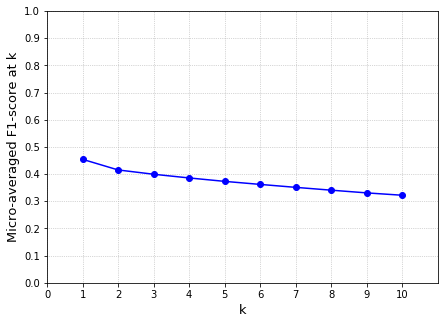

In [19]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
    0.4542846898529939,0.4152191894127378,
    0.3993811881188119,0.38577112099227706,
    0.3732075471698113,0.36203020612354747,
    0.35116380723418206,0.34080631194072936,
    0.3307950438822922,0.322143732850721
]
plot_micro_f1_at_k(validation_scores,ax=ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()